<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Визуализация-временного-ряда" data-toc-modified-id="Визуализация-временного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Визуализация временного ряда</a></span></li><li><span><a href="#Оценка-стационарности-временного-ряда-с-помощью-теста-Дика-Фуллера" data-toc-modified-id="Оценка-стационарности-временного-ряда-с-помощью-теста-Дика-Фуллера-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Оценка стационарности временного ряда с помощью теста Дика-Фуллера</a></span></li><li><span><a href="#Декомпозиция-временного-ряда" data-toc-modified-id="Декомпозиция-временного-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Декомпозиция временного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Регрессия-случайного-леса" data-toc-modified-id="Регрессия-случайного-леса-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Регрессия случайного леса</a></span></li><li><span><a href="#Регрессия-CatBoost" data-toc-modified-id="Регрессия-CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Регрессия CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Проверка-на-адекватность-лучшей-модели" data-toc-modified-id="Проверка-на-адекватность-лучшей-модели-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Проверка на адекватность лучшей модели</a></span></li></ul></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Обзор данных

Импортируем нужные библиотеки, считаем данные из датасетов и напишем функцию, отвечающую за их первичный анализ.

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# начальное состояние генератора случайных чисел
RANDOM_STATE = 12345
# количество лагов для обучения моделей
LAGS_COUNT = 20

In [4]:
# Считаем датафрейм
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

# отсортируем индекс временного ряда
data.sort_index(inplace=True)

In [5]:
# напишем функцию, выполняющую первичный анализ данных
def overview_data(data):
    # выведем первые 20 строк
    display(data.head(20))
    # выведем информацию о датафрейме
    data.info()
       
    # построим общую гистограмму для всех числовых признаков
    data.hist(figsize=(10, 10), bins=20);
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.show()
    
    # выведем описание данных
    display(data.describe())
    
    # проверим, является ли уникальным значения индекса
    is_unique = data.index.is_unique
    print('Уникальность индекса датафрейма', is_unique)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


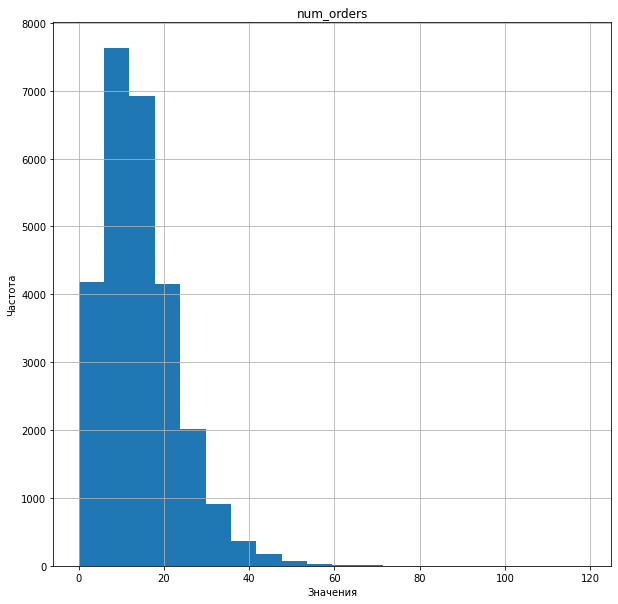

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Уникальность индекса датафрейма True


In [6]:
# выполним первичный анализ данных для датафрейма
overview_data(data)

Выполним ресемплирование по одному часу с суммированием значений за час по требованию задачи:

In [7]:
# выполним ресемплирование по одному часу
data = data.resample('1H').sum()
# проверим, что ресемплирование произошло
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div style="border:solid green 2px; padding: 20px">
    
Результаты обзора данных:

* Пропусков в данных нет
* Значения индекса уникальны
* Целевой признак временного ряда находится в реалистичном диапазоне
    
</div>

## Анализ

### Визуализация временного ряда

Построим график временного ряда:

In [8]:
# добавим функцию, добавляющую подписи заголока, осей и сетку на график
def decorate_plot(plt, title, xlabel = ' Дата', ylabel = 'Количество заказов'):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

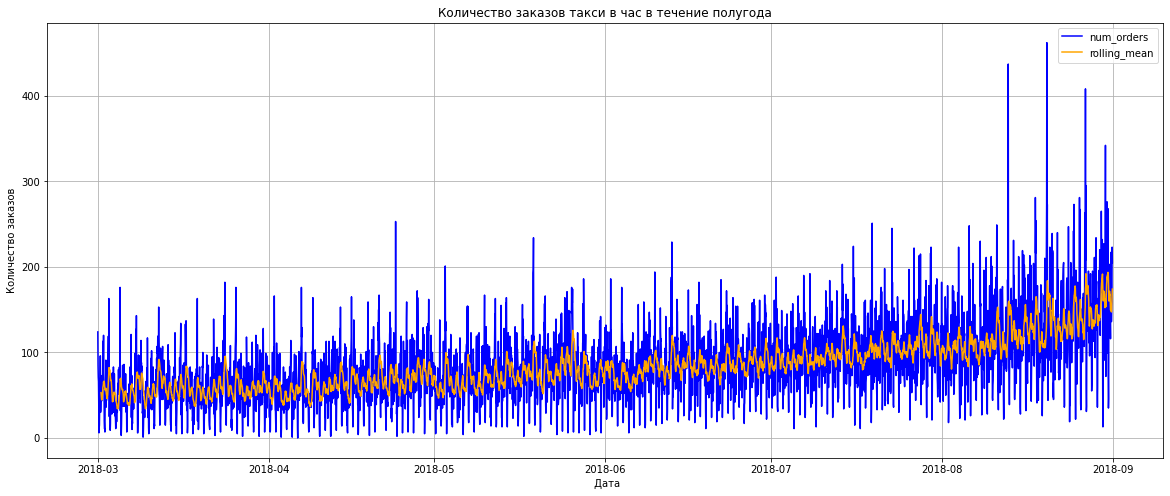

In [9]:
# рассчитаем скользящее среднее
data['rolling_mean'] = data.rolling(15).mean()

plt.figure(figsize=(20, 8))

plt.plot(data['num_orders'], label='num_orders', color='blue')
plt.plot(data['rolling_mean'], label='rolling_mean', color='orange')
plt.legend()

decorate_plot(plt, 'Количество заказов такси в час в течение полугода')

plt.show()

Выберем произвольную неделю в середине временного ряда, чтобы рассмотреть поближе этот график:

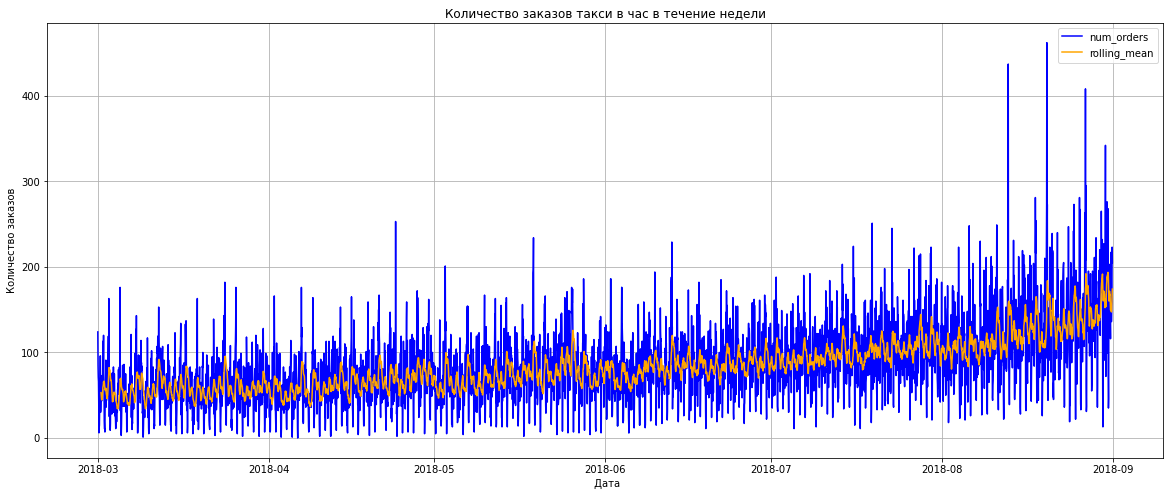

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(data['2018-06-01':'2018-06-07'])

plt.plot(data['num_orders'], label='num_orders', color='blue')
plt.plot(data['rolling_mean'], label='rolling_mean', color='orange')
plt.legend()

decorate_plot(plt, 'Количество заказов такси в час в течение недели')

plt.show()

* По общему графику видно, что в среднем количество заказов увеличивается. 
* По графику количества заказов в течение недели предположим, что есть суточная цикличность, так как пики примерно в одно и то же время. Далее проверим это с помощью разложения временного ряда на составляющие.
* Скользящее среднее со временем увеличивается, следовательно сделаем предположение, что ряд не стационарен, и его сложнее прогнозировать. 

### Оценка стационарности временного ряда с помощью теста Дика-Фуллера

Воспользуемся еще одним способом оценки стационарности временного ряда - тестом Дика-Фуллера. Нулевая гипотеза будет - временной ряд не стационарен, альтернативная гипотеза - ряд стационарен. Для уменьшения влияния шумов проведем ресемплирования данных до дня.

In [11]:
# удалим столбец со скользящим средним, так как далее в проекте он не требуется
data = data.drop('rolling_mean', axis=1)

# выполним ресемплирование по одному дню
data_per_days = data.resample('1D').sum()

# проведем тест Дика-Фуллера
adfuller_result = adfuller(data_per_days['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % adfuller_result[0])

print('P-значение: %f' % adfuller_result[1])

print('Критические значения:')

for key, value in adfuller_result[4].items():
    print('\t%s: %.3f' % (key, value))
if adfuller_result[0] < adfuller_result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: 3.728791
P-значение: 1.000000
Критические значения:
	1%: -3.469
	5%: -2.879
	10%: -2.576
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


Наше предположение подтвердилось, ряд не стационарен.

### Декомпозиция временного ряда

Разложим временной ряд на составляющие:тренд, сезонность и остаток и построим их графики:

In [12]:
def drow_decomposed_data(data, suptitle):
    decomposed = seasonal_decompose(data)

    fig = plt.figure(figsize=(20, 20))

    # отобразим тренд
    plt.subplot(311)
    # Чтобы график корректно отобразился, указываем его
    # оси ax, равными plt.gca() (англ. get current axis,
    # получить текущие оси)
    decomposed.trend.plot(ax=plt.gca())
    decorate_plot(plt, 'Тренд')

    # отобразим сезонность
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca()) 
    decorate_plot(plt, 'Сезонность')
    
    # отобразим остаток
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca()) 
    decorate_plot(plt, 'Остаток')
    plt.tight_layout()
    
    fig.suptitle(suptitle)
    
    plt.show()

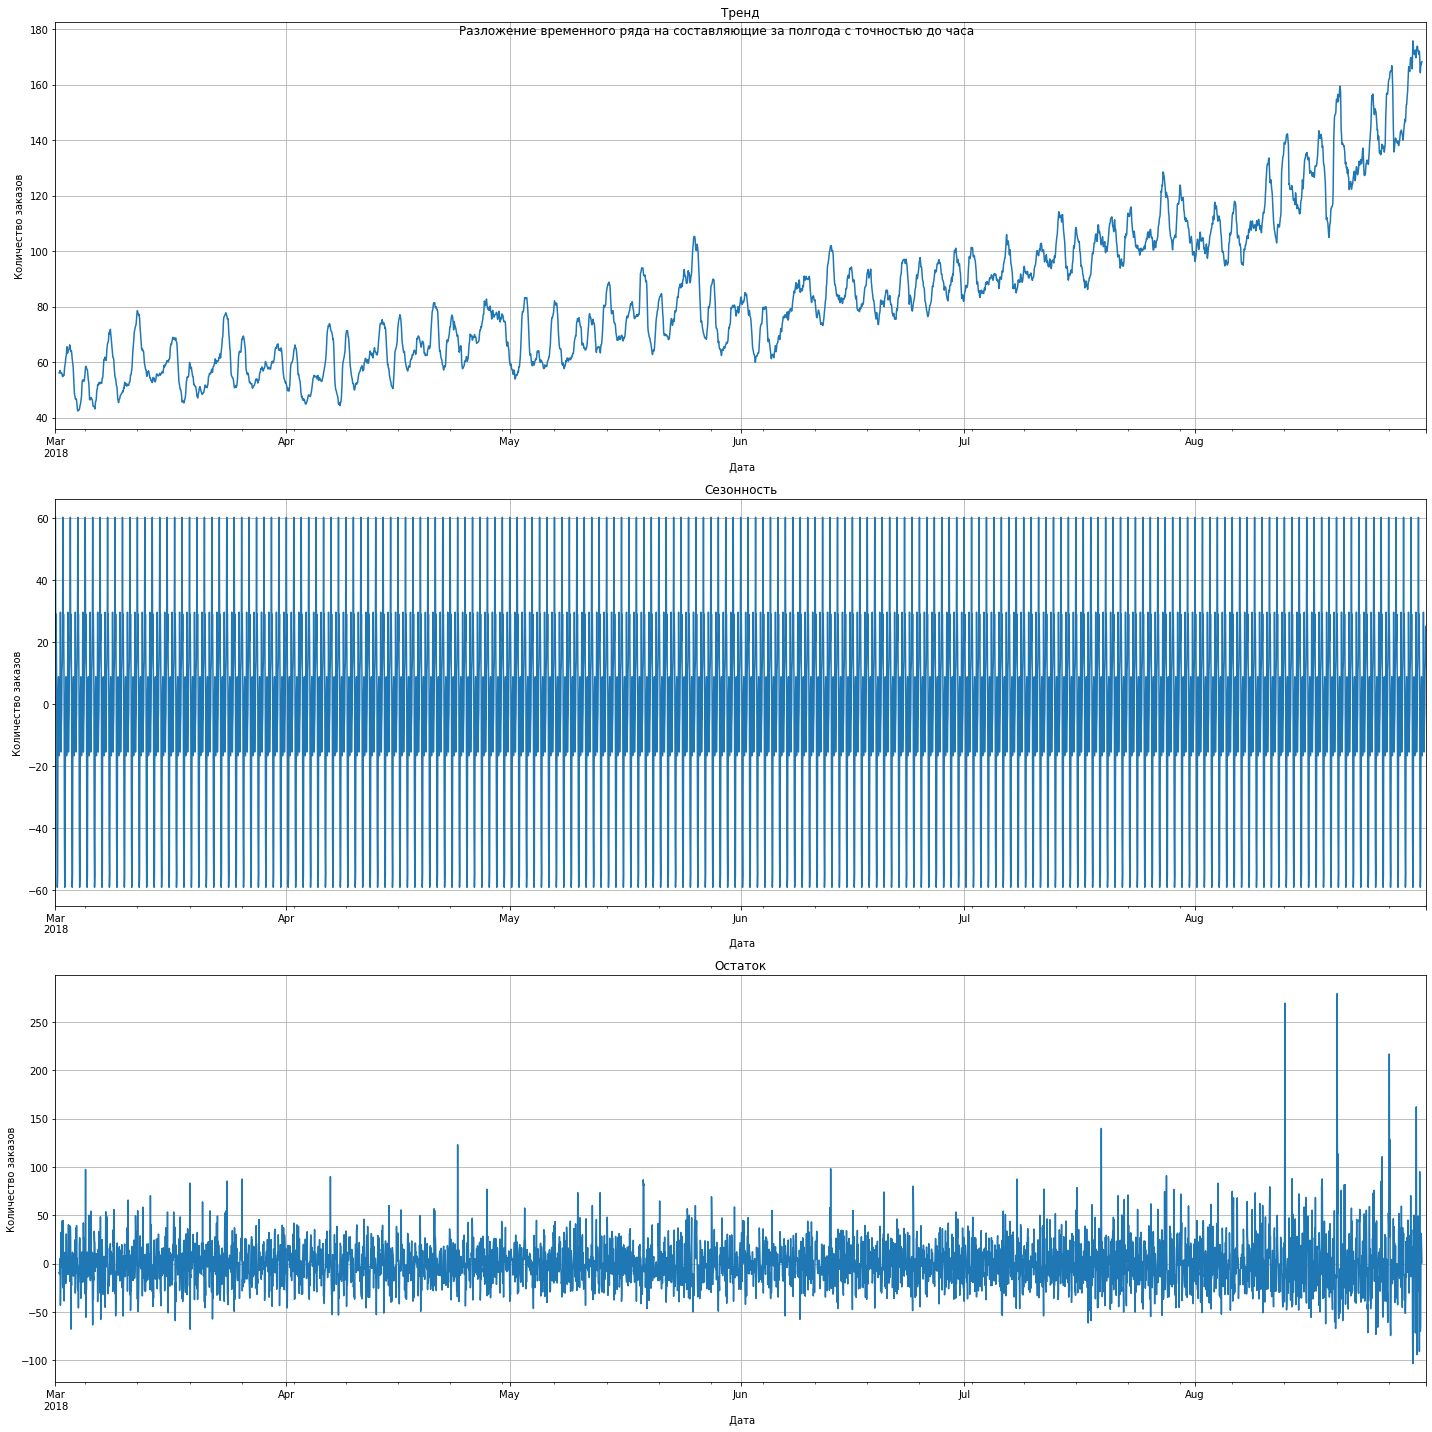

In [13]:
# применим функцию к всему временному ряду
drow_decomposed_data(data, 'Разложение временного ряда на составляющие за полгода с точностью до часа')

Графики сезонности и остатка удобнее рассмотреть в произвольные 2 недели, возьмем за первую половину июня:

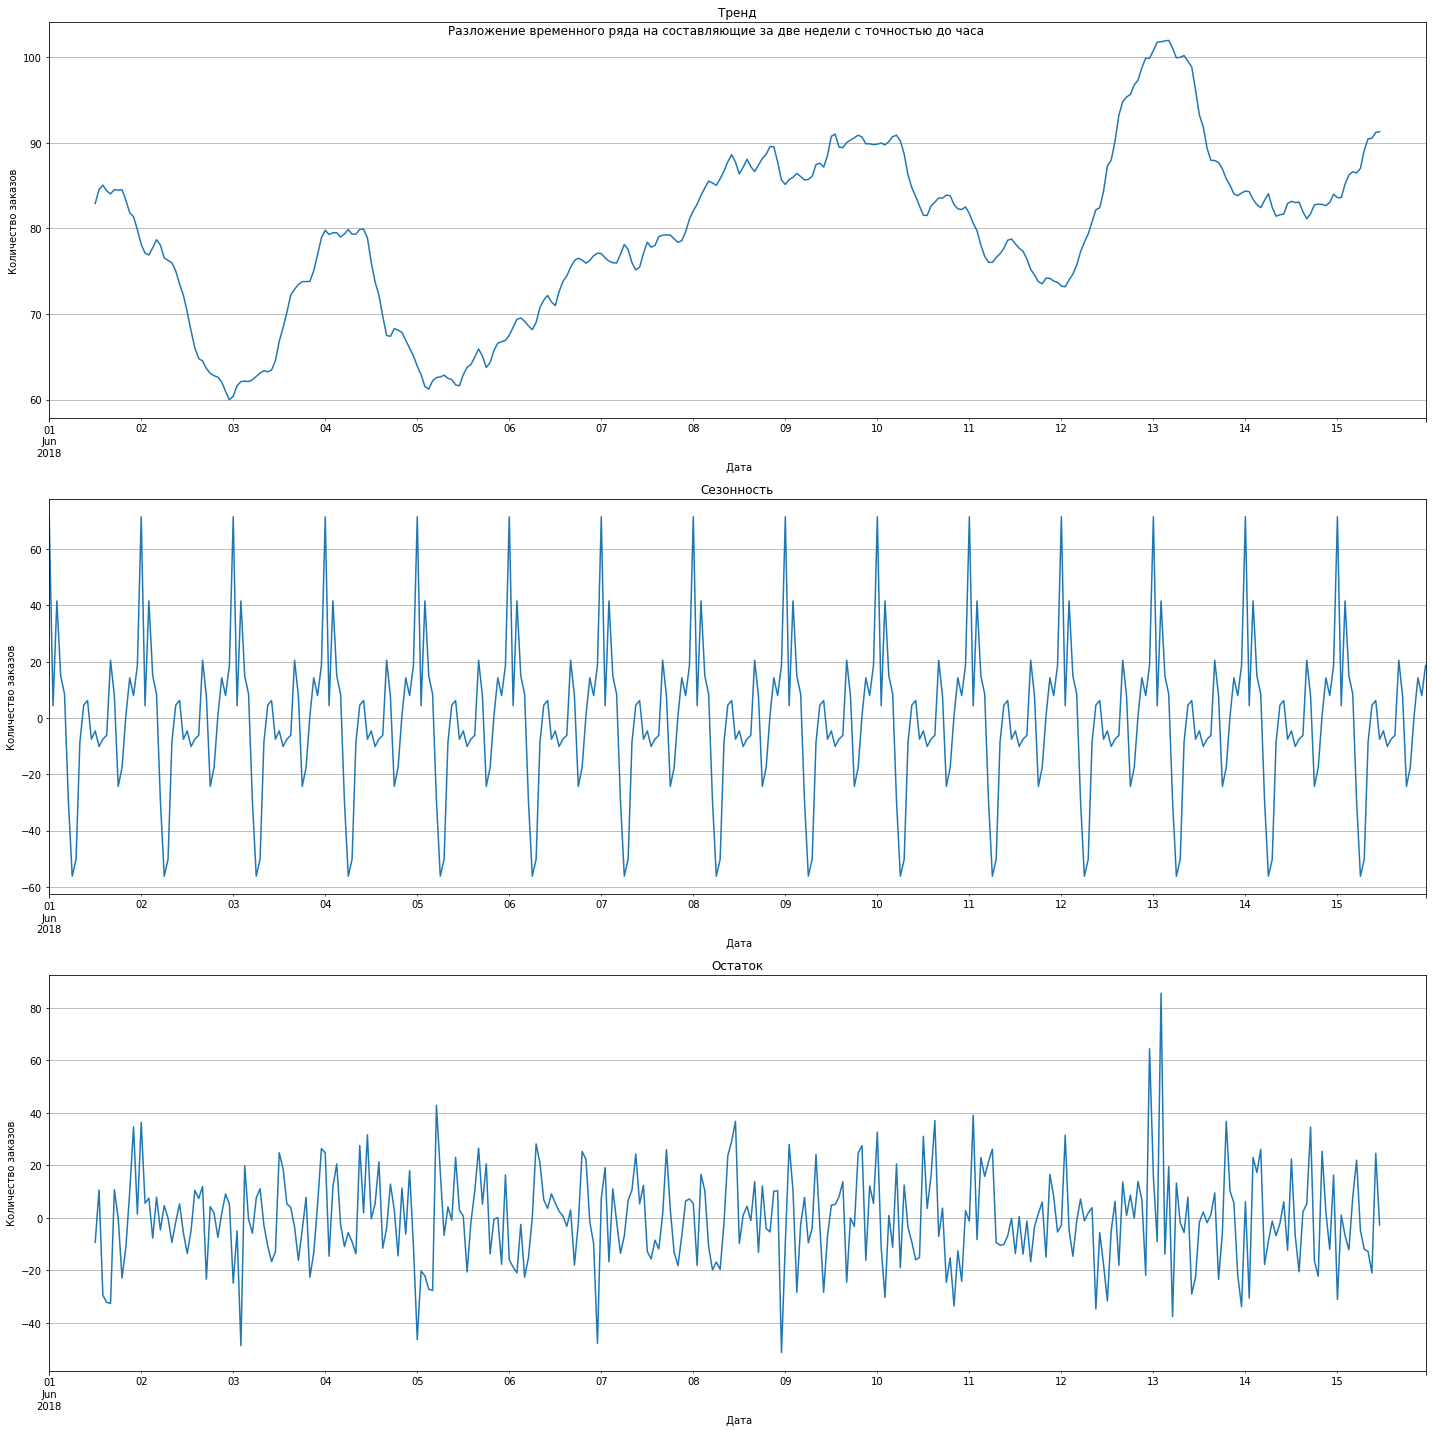

In [14]:
drow_decomposed_data(data['2018-06-01':'2018-06-15'], 'Разложение временного ряда на составляющие за две недели с точностью до часа')

График сезонности периодический с периодом в одни сутки. Для анализа сезонности с точностью до дня, проведем ресемплирования данных до дня и посмотроим графики после декомпозиции временного ряда за 3 недели, для удобства будем смотреть с понедельника с 04.06.2018:

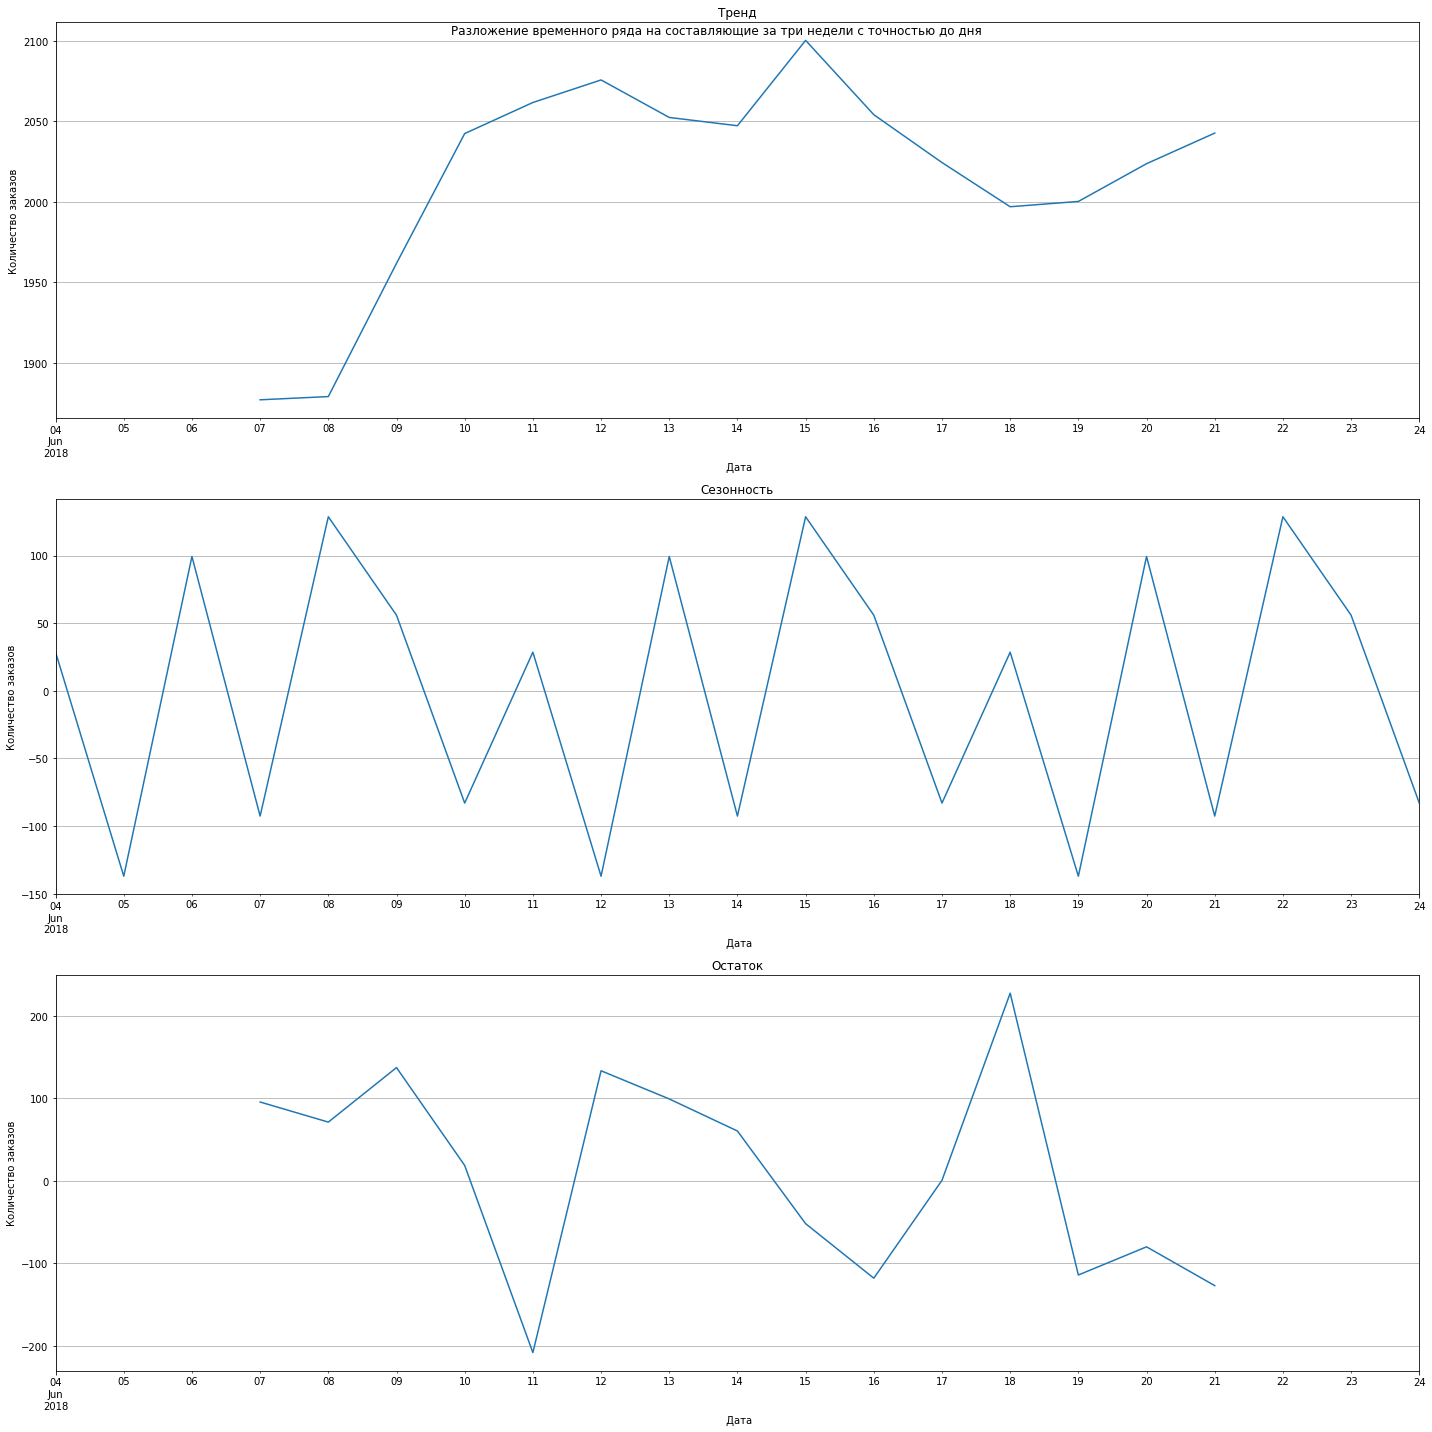

In [15]:
drow_decomposed_data(data_per_days['2018-06-04':'2018-06-24'], 'Разложение временного ряда на составляющие за три недели с точностью до дня')

<div style="border:solid green 2px; padding: 20px">
    
* Тренд восходящий, т.е. среднее значение числа заказов возрастает примерно с 55 до 150 заказов в час.
* График сезонности периодический с периодом в одни сутки. Самый большой всплеск около 12 ночи, также есть утренний и вечерние всплески. Вероятно, это связано с регулярными рейсами, которые совершаются в одно и то же время, к которым привязаны заказы такси. Ночью общественный транспорт часто не ходит, поэтому наблюдаем всплеск заказов ночью.
* На графике сезонности с точностью до суток заметим  всплески заказов в середине недели и на выходных.
* Скользящее среднее со временем увеличивается, следовательно ряд не стационарен, и его сложнее прогнозировать. Также провели тест Дика-Фуллера, он также подтвердил, что ряд не стационарен.

</div>

## Обучение

Попробуем разные модели для решения задачи, для оценки качества моделей применим метрику RMSE. По требованию задачи значение метрики RMSE на тестовой выборке должно быть не больше 48.

Подготовим признаки для обучения моделей: добавим признак час, день, день недели. Также добавим несколько отстающих значений, их число будем передавать в параметы функции, подготавливающей данные, и добавлять нужное число лагов. Далее экпериментально будет подбирать оптимальное число лагов.

In [16]:
def add_features(data, lags_count):
    data = pd.DataFrame(data.copy())
    
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['weekday'] = data.index.weekday
    
    for lag in range(1, lags_count + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)     
    # удалим пропуски в лагах
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    return data

Для упрощения напишем функцию, которая с помощью GridSearchCV подбираем лучшую модель по метрике RMSE среди переданных параметров.

In [17]:
# добавь передачу числа итераций в модель
def find_best_model_rmse(model, parameters):
    # объект для валидациии временных рядов
    tscv = TimeSeriesSplit(n_splits=3)
    grid_search = RandomizedSearchCV(
        model, parameters, scoring='neg_root_mean_squared_error', cv=tscv, n_iter=10, n_jobs=-1)
    grid_search.fit(features_train, target_train)

    print('Наилучшая модель', grid_search.best_params_)
    print('RMSE наилучшей модели', abs(grid_search.best_score_))
    
    return grid_search.best_estimator_, abs(grid_search.best_score_)

Экспериментально выбрали число лагов 20 для подготовки данных к обучению. Далее Подготовим выборки для обучения:

In [18]:
data = add_features(data, LAGS_COUNT)
display(data.head())

,num_orders,hour,day,weekday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
0,61,20,1,3,45.0,73.0,44.0,43.0,66.0,48.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
1,66,21,1,3,61.0,45.0,73.0,44.0,43.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2,113,22,1,3,66.0,61.0,45.0,73.0,44.0,43.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
3,58,23,1,3,113.0,66.0,61.0,45.0,73.0,44.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
4,90,0,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


In [19]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)

### Линейная регрессия

In [20]:
%%time
lr_model = LinearRegression(normalize= True, fit_intercept=False)
#lr_parameters = {'fit_intercept' : [True, False], 'normalize' : [True, False]}
lr_parameters = {}

CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 18.4 µs


In [21]:
lr_best_estimator, lr_best_score = find_best_model_rmse(lr_model, lr_parameters)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Наилучшая модель {}
RMSE наилучшей модели 32.68548897905776


### Регрессия случайного леса

In [22]:
%%time
rfr_model = RandomForestRegressor(random_state=RANDOM_STATE)
rfr_parameters = {"n_estimators": [100, 200, 300], 'max_depth': [None] + [i for i in range(2, 7)]}

CPU times: user 466 µs, sys: 93 µs, total: 559 µs
Wall time: 97.8 µs


In [23]:
rfr_best_estimator, rfr_best_score = find_best_model_rmse(rfr_model, rfr_parameters)

Наилучшая модель {'n_estimators': 200, 'max_depth': None}
RMSE наилучшей модели 27.621415795503722


### Регрессия CatBoost

In [24]:
%%time
cbr_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
cbr_parameters = {'depth': [4, 6, 8], 'learning_rate': [0.03, 0.1, 0.2], 'l2_leaf_reg': [3, 5, 7]}

cbr_best_estimator, cbr_best_score = find_best_model_rmse(cbr_model, cbr_parameters)

Наилучшая модель {'learning_rate': 0.03, 'l2_leaf_reg': 3, 'depth': 4}
RMSE наилучшей модели 26.759080806136367
CPU times: user 2min 29s, sys: 2.49 s, total: 2min 31s
Wall time: 2min 58s


<div style="border:solid green 2px; padding: 20px">
    
* Наилучший результат по метрике RMSE выдали модель градиентного бустинга CatBoost - 27.0. Далее идет модель случайного леса с RMSE 27.6. Наихудший результат RMSE у линейной регрессии 32.6.
* Для решения задачи прогнозирования количества заказов выберем модель CatBoost.

</div>

## Тестирование

###  Тестирование лучшей модели

Проверим, как лучшая модель CatBoost отрабатывает на тестовой выборке:

In [25]:
# определим функцию, вычиляющую RMSE модели на тестовой выборке
def test_model(best_estimator):
    predictions_test = best_estimator.predict(features_test)

    rmse_test =  np.sqrt(mean_squared_error(target_test, predictions_test))
    print('Итоговый RMSE на тестовой выборке', rmse_test) 

In [26]:
# протестируем модель CatBoost
test_model(cbr_best_estimator)

Итоговый RMSE на тестовой выборке 43.25882054738492


### Проверка на адекватность лучшей модели

Сравним, как соотносятся полученные результаты с результатами фиктивного регрессора, который всегда будет предсказывать предыдущее значение временного ряда:

In [27]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse_fake_model =  np.sqrt(mean_squared_error(target_test, pred_previous))
print("Итоговый RMSE  фиктивного регрессора на тестовой выборке:", rmse_fake_model)


Итоговый RMSE  фиктивного регрессора на тестовой выборке: 58.881776776551476


<div style="border:solid green 2px; padding: 20px">
    
* Наилучшая модель CatBoost на тестовой выборке вычислила RMSE 42.2, что в 1.6 раз хуже, чем на тренировочной выборке: 27.0. Это означает, что модель переобучилась.
* Сравнили результат наилучшей найденной модели CatBoost с фиктивным регрессором, который всегда будет предсказывать предыдущее значение: на тестовой выборке модель CatBoost показала RMSE 42.2, а фиктивный регрессор 58.9. В отличие от фиктивного регрессора CatBoost укладывается в требуемое в задаче значение RMSE на тестовой выборке не больше 48.
    
</div>

## Общие выводы

<div style="border:solid green 2px; padding: 20px">
    
* В проекте **требовалось построить модель, количество заказов такси на следующий час** для компании, предоставляющей услуги такси.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* Данные содержат количество заказов такси в определенный промежуток времени.
* Пропусков в данных нет
* Значения индекса уникальны
* Целевой признак временного ряда находится в реалистичном диапазоне
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* **Тренд временного ряда восходящий**, т.е. среднее значение числа заказов возрастает примерно с 55 до 150 заказов в час.
* **График сезонности периодический с периодом в одни сутки.**  Самый большой всплеск около 12 ночи, также есть утренний и вечерние всплески. Вероятно, это связано с регулярными рейсами, которые совершаются в одно и то же время, к которым привязаны заказы такси. Ночью общественный транспорт часто не ходит, поэтому наблюдаем всплеск заказов ночью.
* На графике сезонности с точностью до суток **заметили всплески заказов в середине недели и на выходных.**
* Скользящее среднее со временем увеличивается, следовательно **ряд не стационарен**, и его сложнее прогнозировать. Также был проведен тест Дика-Фуллера, он также подтвердил, что ряд не стационарен.
   
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------   
* **Наилучший результат по метрике RMSE выдали модель градиентного бустинга CatBoost: 27.0.** Далее идет модель случайного леса с RMSE 27.6. Наихудший результат RMSE у линейной регрессии 32.6.
* Для решения задачи прогнозирования количества заказов **выбрали модель CatBoost**.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* Наилучшая модель CatBoost на тестовой выборке вычислила RMSE 42.2, что в 1.6 раз хуже, чем на тренировочной выборке: 27.0. Это означает, что **модель переобучилась**.
* Сравнили результат наилучшей найденной модели CatBoost с фиктивным регрессором, который всегда будет предсказывать предыдущее значение: на тестовой выборке модель CatBoost показала RMSE 42.2, а фиктивный регрессор 58.9. **В отличие от фиктивного регрессора CatBoost укладывается в требуемое в задаче значение RMSE на тестовой выборке не больше 48.**
    
</div>